## 1. Multinomial GLM-HMM

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Subdirectory 'data-aspects-dir' created successfully for the file to be saved in.


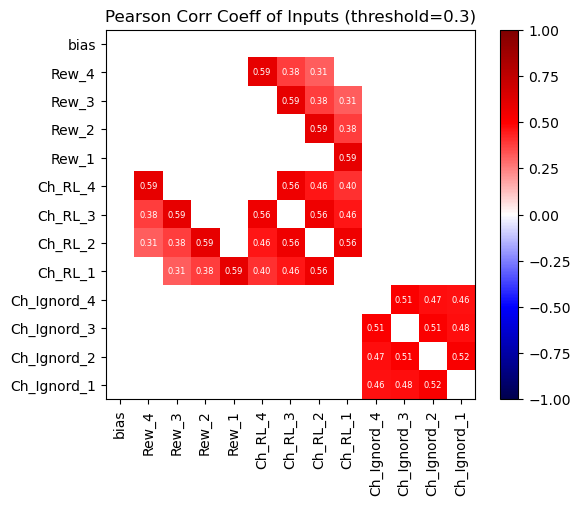

In [1]:
"""
the python environment for the code: conda activate ssm_env_python3_9 
type_save= 'data-aspects' # can be ['data-aspects' , 'HMM-latent-satas']
"""

from f_util_preprocess import *
from f_util_plot import *
from f_util_analyses import *

hparams = {
    'data_dir': get_path_to_data_dir(),
    'save_dir': get_path_to_save_dir(),
    'mouse' : 'HH10', # [FOR07, HH09, HH10]
    'experiment' : 'blockRew-coupled-baited',
    'data_type' : '.npy',
    'num_history_step' : 4,
    'num_hidden_states' : [1,2,3],
    'GLM' : 'multinomial', # can be ['bernoulli' , 'multinomial']
    'bias' : True,
    'bias_to_rich' : False,
    'water' : False,
    'obs_dim' : 1 ,          # number of observed dimensions
    'num_categories' : 3,   # number of categories for output
    'cols' : set_color_pallete(),
    'analysis_experiment_name' : 'modified_Bari', # choose from the list ['modified_Bari', 'bias_RewardOneHot_ChoiceOneHot', 'just_bias']     ['just_bias', 'bias_RewardOneHot', 'bias_ChoiceOneHot', \
    # 'bias_RewardOneHot_ChoiceOneHot', 'bias_RewardOneHot_Choice1FeatureNAN', 'bias_RewardBinary_ChoiceOneHot', 'bias_RewardWSLS_1FeatureChoiceNAN', 
    # 'bias_RewardOrdinal_Choice1Hot', 'bias_RewardWSLS_ChoiceOneHot']
    'num_iters' : 500,
    'tolerance' : 10**-5,
    'alphas' : [1, 2],
    'sigmas' : [0.5, 2], #[0.5, 0.75, 1, 2, 3, 4] #[0.5, 2] # [2, 3] 
    'output_form' : 'R0_nan1_L2',  # can be chosen from ['R0_L1_nan2', 'R0_nan1_L2']
    'observation_dim' : 1,
    'n_iters' : 500,
    'colors' : ['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#999999', '#e41a1c', '#dede00', '#a65628', '#984ea3', '#97945a', '#c1cdc1',\
    '#00FFFF', '#FF00FF', '#FFA500', '#7FFFD4', '#00008B', '#00FF00', '#F7E7CE', '#EAC117', '#B275F7', '#9FDEBF'],
    'category_rew_prob' : [0.45,  0.4,   0.386, 0.338, 0.225, 0.113, 0.071, 0.064, 0.05 ],  
    'Sess_format': True
}


hparams['input_dim'] = n_input_dim(hparams)
hparams['alpha_sigma_sets'] = generate_hyperparameter_sets_for_mle_map(hparams['alphas'] , hparams['sigmas']) #"alpha_sigma_sets" used to be "hyperparameter_sets"

data = import_data(hparams['data_dir'] + hparams['mouse'] + hparams['data_type']) # DataFrame of size 5*n_sessions, 
# To call data of, for example, choice_history of session 2, use this form: data[2]['choice_history'], which is a numpy.ndarray of size (1 , n_trilas)

    # ''' 
    # Export all foraging sessions (for Faeze)
    #
    # The dictionary in each .npy file uses session number as the key
    # {1: {'choice_history': 1-d array, 0 = left, 1 = right, nan = ignored
    #      'reward_history': 2-d array, first dimension: left [0] / right [1], second dimension: trial number. 0 = no reward, 1 = rewarded
    #      'p_reward': underlying reward refill probabilities. Same structure as reward_history
    #      'trial_num': total trial number (including ignored trials)
    #      'foraging_efficiency': overall performance of this session
    #      },
    #  2: data for session 2,
    #  ...
    # }
    # '''
hparams['sessions'] = np.arange(1,np.shape(data)[1]+1)
hparams['tot_n_sess'] = np.shape(data)[1]
hparams['list_of_trial_count_in_chosen_sessens'] = get_list_of_trial_count_in_chosen_sessens(hparams, data)
hparams['num_input_trials_segr_by_sessions'] = get_list_of_num_trials_for_chosen_sess_in_input_array(hparams)
hparams['block_divider_trials'] = np.array(get_block_divider_in_selected_sess(hparams,data))
hparams['sess_divider_trials'] = np.array(get_sess_divider_in_selected_sess(hparams))

hparams['input_labels'] = get_input_labels(hparams)
hparams['num_trials_in_input_array'] = get_n_trials_for_input_array(hparams)
if hparams['GLM'] == 'multinomial':
    hparams['num_categories'] = 3
else:
    hparams['num_categories'] = 2



input_design_matrix_list = build_input_design_matrix(hparams, data)
output_choice_list = build_output_choice_list(hparams, data)

if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.3)
    plot_name = 'pearson_coeff' + '-' + hparams['mouse'] + '-' + hparams['analysis_experiment_name']
    save_plot(hparams, type_save= 'data-aspects', plot_name = plot_name)


### fold stuff to be done later ###
# num_folds = 5 # num_fold in training part
# num_folds_tt = num_folds +1
# test_fold_id = np.random.randint(0,num_folds+1, 1)
# # test_fold_id =0 ##############remive it

# print('test_fold_id : ', test_fold_id)

Until now, we have only considered the case where there are 2 output classes (the Bernoulli GLM-HMM corresponding to `C=num_categories=2`), yet the `ssm` framework is sufficiently general to allow us to fit the multinomial GLM-HMM described in Equations 1 and 2. Here we demonstrate a recovery analysis for the multinomial GLM-HMM. 

In [2]:
np.shape(data)[1]

81

Text(0, 0.5, '# trial/ sess')

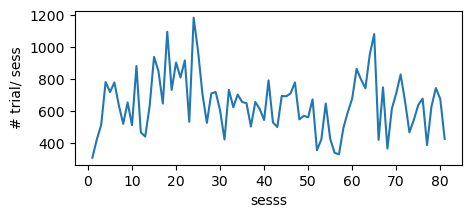

In [3]:
fig = plt.figure(figsize=(5,2))
plt.plot(hparams['sessions'] , hparams['num_input_trials_segr_by_sessions'])
plt.xlabel('sesss')
plt.ylabel('# trial/ sess')

/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/faezeamin/opt/anaconda3/envs/ssm_env_python3_9/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


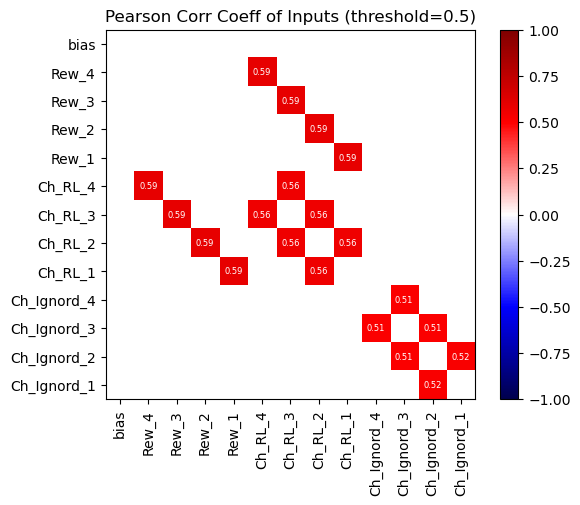

In [4]:
import ssm

"""
n_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
"""

hparams_analyses = {
    'decorrelate_input' : False,
}


# npr.seed(0)
# Set the parameters of the GLM-HMM
# num_states =  2      # number of discrete states
obs_dim = hparams['observation_dim']        # number of observed dimensions
num_categories = hparams['num_categories']    # number of categories for output
input_dim = hparams['input_dim']         # input dimensions


if hparams_analyses['decorrelate_input'] == True: 
    input_design_matrix_list = decompose_input_list(input_design_matrix_list)[0]
    # a,b,pca_ = decompose_input_list(input_design_matrix_list)
    hparams['input_labels'] = ['PC' + str(i) for i in range(1, hparams['input_dim']+1)]
    
if np.shape(input_design_matrix_list)[2] > 1:
    plot_heatmap_of_pearson_corr_coeff_of_input_data(hparams, input_design_matrix_list, threshold = 0.5)
    # im = plt.imshow(np.cov(input_design_matrix_list[0], rowvar=False), cmap="seismic")#, vmin=-1, vmax=1)
    # im = plt.imshow(np.corrcoef(input_design_matrix_list[0].T), cmap="seismic", vmin=-1, vmax=1)
    # plt.colorbar(im)

true_choices = output_choice_list
inpts = input_design_matrix_list
# a = np.array(input_design_matrix_list).squeeze().reshape(-1,17)[:,:2]
# input_design_matrix_list_1 = []
# input_design_matrix_list_1.append(a)
# inpts = input_design_matrix_list_1

# mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")

In [5]:
np.shape(input_design_matrix_list)

(1, 52532, 13)

In [6]:
# dataset = np.array(input_design_matrix_list).squeeze()
# transformed_data,loadings, pca_object=decompose_correlated_data_using_PCA(dataset)

# fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# for j in range(0,3):
#     axes[0].plot(pca_object.inverse_transform(weights[j,0,:]), color=hparams['colors'][j])

# for j in range(0,3):
#     axes[1].plot(pca_object.inverse_transform(weights[j,1,:]), c=hparams['colors'][j])

# # for j in range(3):
# #     axes[1].plot(c.inverse_transform(weights[j,2,:]), c=hparams['colors'][j])

# for ax in axes:
#     ax.set_xticks(range(13))
#     ax.set_xticklabels(hparams['input_labels'], rotation = 90)
#     # ax.set_ylim([-2,2])

# plt.subplots_adjust(hspace=0.3)

In the above, notice that the shape of the weights for the multinomial GLM-HMM is `(num_states, num_categories-1, input_dim)`.  Specifically, we only learn `num_categories-1` weight vectors (of size `input_dim`) for a given state, and we set the weights for the other observation class to zero. Constraining the weight vectors for one class is important if that we want to be able to identify generative weights in simulated data. If we didn't do this, it is easy to see that one could generate the same observation probabilities with a set of weight vectors that are offset by a constant vector $w_{k}$ (the index k indicates that a different offset vector could exist per state):
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{w_{kc'}^\mathsf{T} u_t\}} = \frac{\exp\{(w_{kc}-w_{k})^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{(w_{kc'}-w_{k})^\mathsf{T} u_t\}}
\end{align}
$$

Equations 1 and 2 at the top of this notebook already take into account the fact that the weights for a particular class for a given state are fixed to zero (this is why $c = C$ is handled differently).

In [7]:
num_states_2cv = range(1,8)
n_repeats=2
heldout_frac=.1
hparams['kw_cv'] = "both_data"
# kw = hparams['kw_cv'] #   """kw: choose from ["true_data", "sythetic_data, "both_data]"""

if hparams['kw_cv'] == "both_data":
    test_ll, train_ll,test_ll_base, train_ll_base = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices, kw=hparams['kw_cv'])
else:
    test_ll, train_ll = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices, kw=hparams['kw_cv'])


1


LP: -30299.0: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


true data
test_true [-0.63333023 -0.63751651]
train_true [-0.63701687 -0.63655175]


LP: -45694.3: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


synthetic data
test_synth [-0.96142875 -0.9534604 ]
train_synth [-0.96129298 -0.96217831]
2


LP: -29526.5: 100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


true data
test_true [-0.59022203 -0.59618754]
train_true [-0.61652058 -0.61590808]


LP: -45833.4: 100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


synthetic data
test_synth [-0.96056121 -0.96243524]
train_synth [-0.96103227 -0.960816  ]
3


In [ ]:
hmm 31000 33000

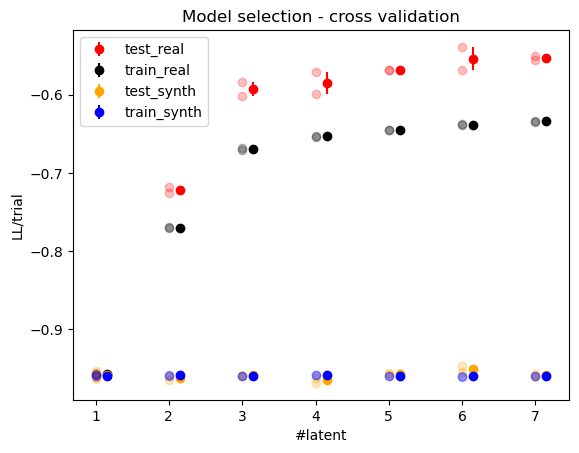

In [8]:
plot_LL_for_model_selection(test_ll, train_ll, test_ll_base, train_ll_base, num_states_2cv= num_states_2cv, kw = hparams['kw_cv'])

In [ ]:
"""Get LL and CV on baseline model, where inputs comes from the mouse, and outputs are generated using a Nernouli model using the same % of R/L/Null actions.
baseline model assumes that animals flip a 3-sided coin on each trial so as to decide to go right, and the probability of going right is equal to the fraction 
of trials in the training set in which the animal chose to go to the right. Baseline model is the log-likelihood of the same test set under a Categorical distribution
 model of animal choice behavior.
"""
# num_states_2cv = range(1,5)
# n_repeats=3
# heldout_frac=.1

test_ll_base, train_ll_base = cv(hparams, num_states_2cv= num_states_2cv, n_repeats=n_repeats, heldout_frac=heldout_frac, inpts=inpts, true_choices= true_choices_simul)

print('test', test_ll)
print('train',train_ll)

In [ ]:
# def generate_synthetic_choice(hparams, true_choices):
#     # choice encoding : 0 = right, 1 = left, 2 = nan (ignored)
#     p_base = np.zeros((3,))
#     true_choice_base =[]
#     for i in range(hparams['num_categories']):
#         p_base[i] = np.sum(np.array(true_choices).squeeze()==i) / hparams['num_trials_in_input_array']

#     categories = [0, 1, 2]

#     # Sample from the categorical distribution
#     choice_base = np.random.choice(categories, size = hparams['num_trials_in_input_array'], p=p_base)
#     true_choice_base.append(choice_base.reshape(-1,1))

#     return true_choice_base


In [74]:
# # ll of baseline model for training set

# # choice encoding : 0 = right, 1 = left, 2 = nan (ignored)
# p_base = np.zeros((3,))
# true_choice_base =[]
# for i in range(num_categories):
#     p_base[i] = np.sum(np.array(true_choices).squeeze()==i) / hparams['num_trials_in_input_array']

# categories = [0, 1, 2]

# # Sample from the categorical distribution
# choice_base = np.random.choice(categories, size = hparams['num_trials_in_input_array'], p=p_base)
# true_choice_base.append(choice_base.reshape(-1,1))

In [ ]:
#     # ll of baseline model for training set
#     random_choice_train = np.random.randint(2, size=np.shape(true_choices_train))
#     baseline_ll_arbitrary_states_train.append(arbitrary_states_glmhmm.log_likelihood(list(random_choice_train), inputs=true_input_train) )

# num_train_trial = (num_sess - num_test_sessions) * num_trials_per_sess
# ll_bit_per_trial_train = (np.array(train_ll_arbitrary_states) - np.array(baseline_ll_arbitrary_states_train)) / (np.log(2) * num_train_trial)

#     # ll of baseline model for training set
#     right_proportion = np.sum(np.array(choices_train)==0) / np.array(choices_train).size
#     num_repetition = 100
#     # random_choices_train = choices_train
#     baseline_ll_train = np.zeros((num_repetition,1))
#     for i in range(num_repetition):
#         # random_choice_train = np.random.randint(2, size=np.shape(choices_train))     # np.shape(choices_train) = (num_sess_train , num_trial_per_sess, 1) like (10, 100, 1)
#         # np.random.shuffle(random_choices_train)  # np.shape(choices_train) = (num_sess_train , num_trial_per_sess, 1) like (10, 100, 1)
#         random_choices_train = np.random.binomial(1, right_proportion, np.shape(choices_train))
#         baseline_ll_train[i] = glm_hmm_mle_map.log_likelihood(list(random_choices_train), inputs=input_train)
#     baseline_ll_train = np.mean(baseline_ll_train)

In [ ]:
def ll_per_trial(ll, ll_baseline, num_trial):
    
    ll_bit_per_trial = (np.array(ll) - np.array(ll_baseline)) / (np.log(2) * num_trial)

    return ll_bit_per_trial

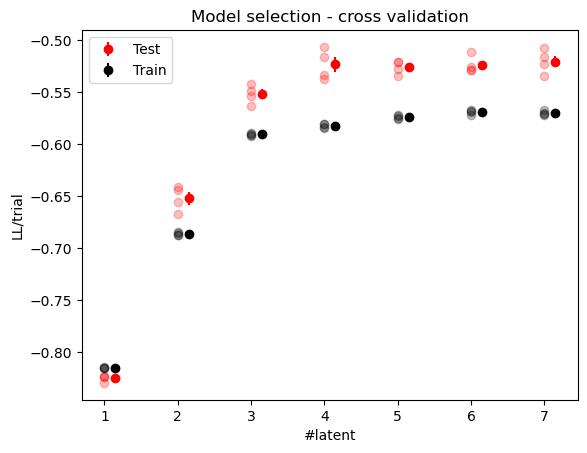

In [ ]:
gg

In [83]:
# # check log_likelihood of fit GLM-HMM for different initialization 
# num_states =  4      # number of discrete states

# for i in range(4):
#     mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
#                    observation_kwargs=dict(C=num_categories), transitions="standard")
    
#     fit_ll = mle_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=hparams['tolerance'])
#     mle_final_ll = mle_glmhmm.log_likelihood(true_choices, inputs=inpts) #/ hparams['num_trials_in_input_array']
#     print(mle_final_ll)


Converged to LP: -23515.8:   9%|▉         | 46/500 [00:13<02:12,  3.43it/s]


-22905.287362956533


Converged to LP: -23666.0:  12%|█▏        | 61/500 [00:16<01:59,  3.68it/s]


-23055.47951282109


Converged to LP: -23665.6:  14%|█▍        | 69/500 [00:22<02:22,  3.02it/s]


-23055.094070412164


Converged to LP: -23683.8:  37%|███▋      | 186/500 [01:05<01:50,  2.84it/s]

-23073.350138446178


In [9]:
num_states =  3     # number of discrete states

mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")

fit_ll = mle_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=hparams['n_iters'], tolerance=hparams['tolerance'])
mle_final_ll = mle_glmhmm.log_likelihood(true_choices, inputs=inpts) #/ hparams['num_trials_in_input_array']
print(mle_final_ll)

Converged to LP: -34712.4:   6%|▌         | 31/500 [00:13<03:25,  2.28it/s]

-34665.44663006503


In [10]:
"""save mpdel"""
# import pickle

# # Create an instance of the class with specific parameters
# instance = mle_glmhmm

# # Save the instance to a file using pickle
# filename = 'instance.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(instance, file)

# print("Instance saved to", filename)

'save mpdel'

In [11]:
"""retreave model"""
# # Load the instance from the file
# filename = 'instance.pkl'
# with open(filename, 'rb') as file:
#     loaded_instance = pickle.load(file)

# print("Loaded instance parameters:")


'retreave model'

In [12]:
weights = mle_glmhmm.observations.params
log_transitions = mle_glmhmm.transitions.params

In [13]:
input_dim

1

In [14]:
weights.shape

(3, 2, 1)

[2 2 2 0 2 2 2 2 0 0 0 0 2 0 0 2 1 2 1 1 2 2 2 1 2 2 2 2 1 2 1 1 1 2 1 0 1
 2 1 2 2 2 0 1 1 1 0 2 1 1 1 1 2 2 0 0 2 1 2 2 1 1 0 2 2 0 0 0 1 1 1 1 1 0
 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 1 1 1 1 1]


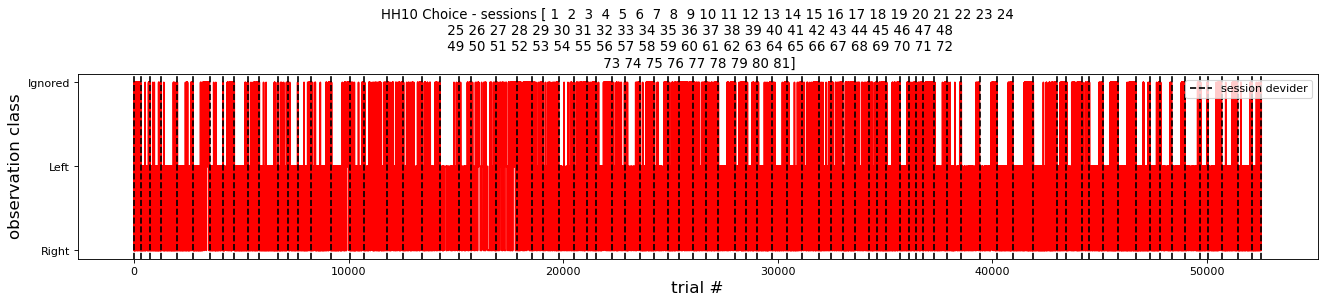

In [15]:
from f_util_plot import *
plot_choice_vs_trials(hparams, true_choices)

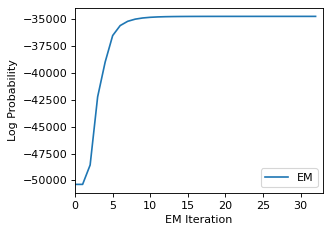

In [16]:
plot_log_prob_of_model_vs_EM_iteration_output_of_fit_fun_training_progress(fit_ll)

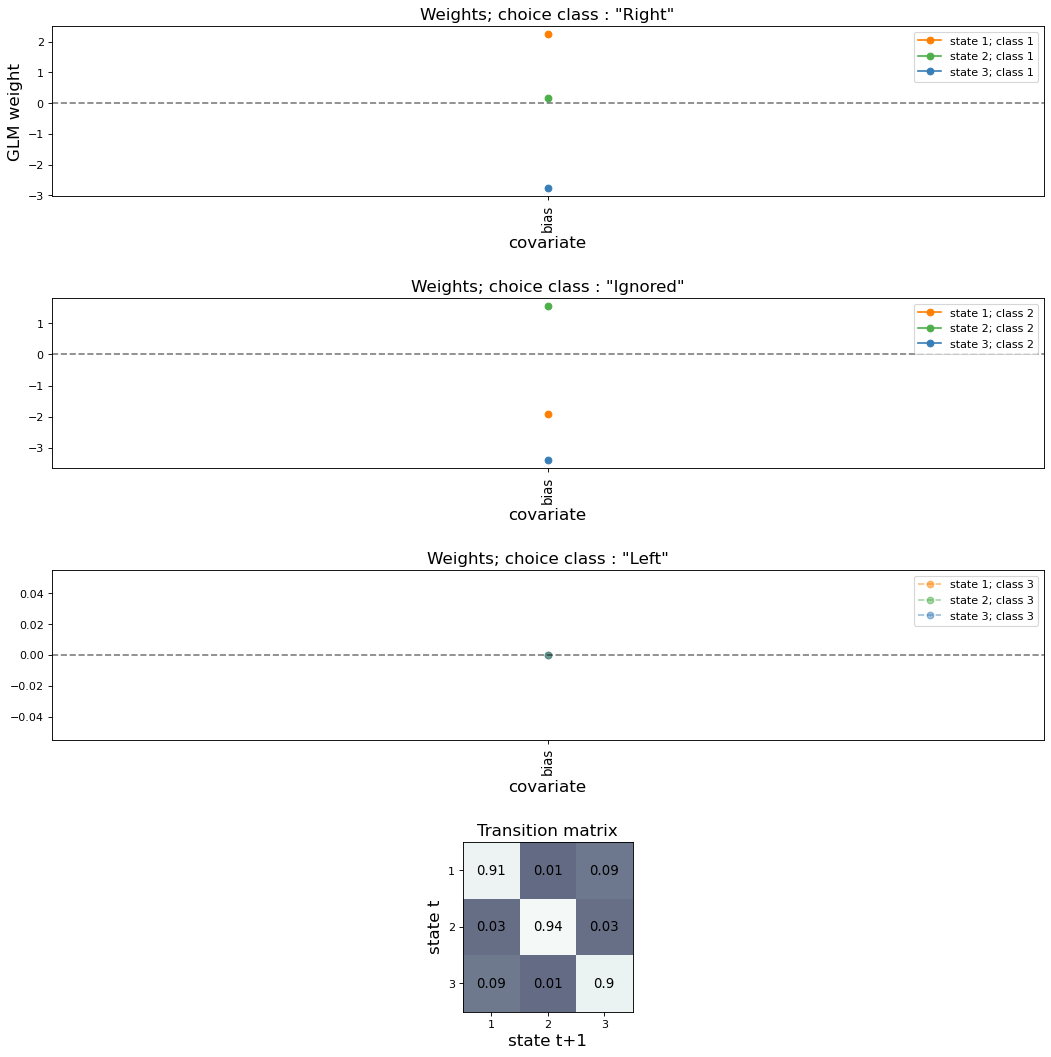

In [17]:
plot_weights_per_class_and_transition_matrix(hparams, weights, log_transitions, num_states)

In [18]:
# Get expected states:
posterior_probs = [mle_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

Text(0, 0.5, 'p(state)')

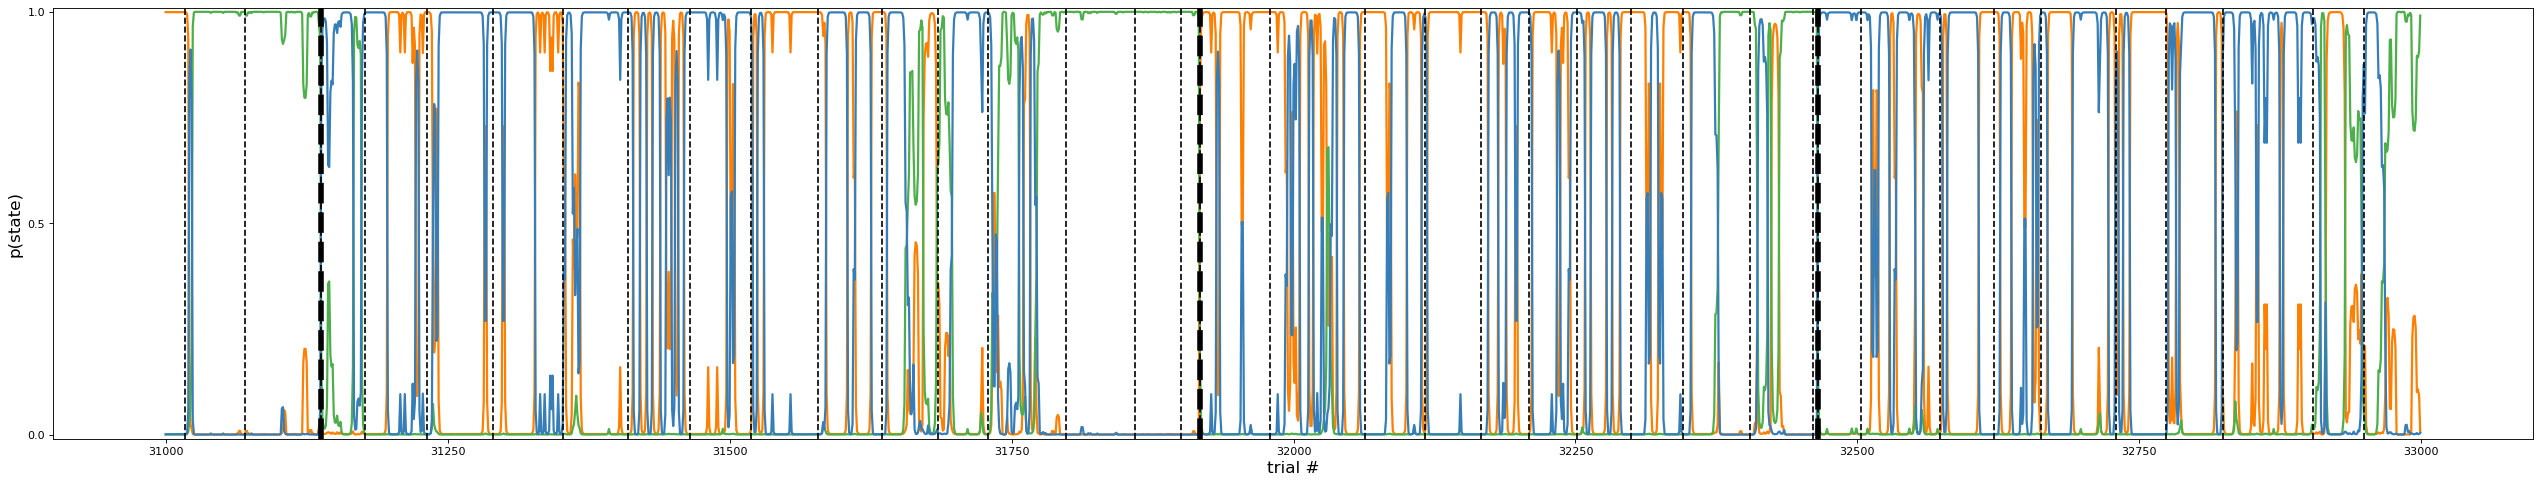

In [19]:
fig = plt.figure(figsize=(40, 7), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; later in rowwise can be choosen any index between 0 and num_sess-1
start = 20000
stop = -1
start = 31000
stop = 33000
# start = 12000
# stop = 23000
if stop == -1: 
    stop = hparams['num_trials_in_input_array']
for k in range(num_states):
    plt.plot(range(start,stop), posterior_probs[sess_id][start:stop, k], label="State " + str(k + 1), lw=2,
             color=hparams['colors'][k])
    

# block_divider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# plt.axvline(x=0, color='black', linestyle='--', label='session devider')
idx = np.arange(np.searchsorted(hparams['block_divider_trials'], start),  np.searchsorted(hparams['block_divider_trials'], stop))
# idx = np.where((np.array(block_divider_trials) >= start) & (np.array(block_divider_trials) <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['block_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--')

# sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['sess_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

    
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)



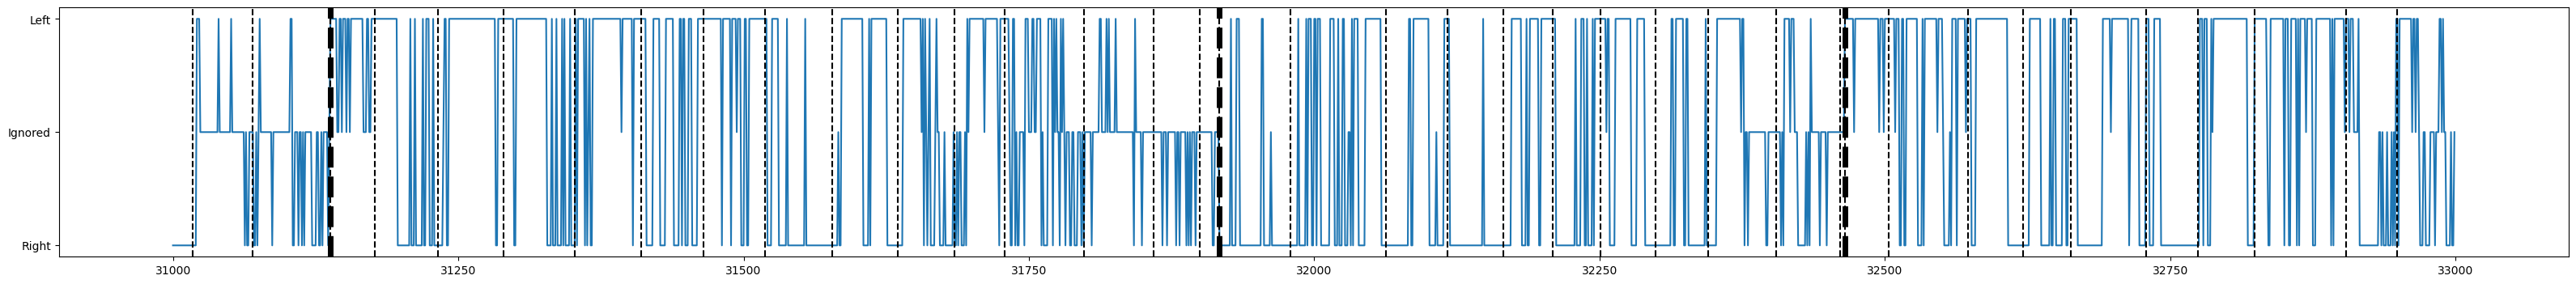

In [20]:
fig = plt.figure(figsize=(40,4))
plt.plot(range(start,stop), true_choices[0][start:stop])
plt.yticks([0, 1, 2], ['Right' , 'Ignored', 'Left'])

# block_devider_trials = np.array(get_block_divider_in_selected_sess(hparams,data))
# plt.axvline(x=0, color='black', linestyle='--', label='session devider')
idx = np.where((np.array(hparams['block_divider_trials']) >= start) & (np.array(hparams['block_divider_trials']) <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['block_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--')

# sess_devider_trials = np.cumsum(np.array(hparams['num_input_trials_segr_by_sessions']))
# sess_divider_trials = np.array(get_sess_divider_in_selected_sess(hparams))
idx = np.where((hparams['sess_divider_trials'] >= start) & (hparams['sess_divider_trials'] <=stop))[0]
if len(idx) >0:
    for num_trials in hparams['sess_divider_trials'][idx]:
        plt.axvline(x=num_trials, color='black', linestyle='--', lw=5)

In [21]:
get_sess_of_trial(hparams, 18000)

26

Text(0, 0.5, 'frac. occupancy')

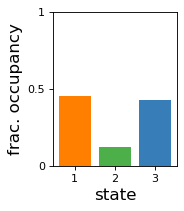

In [22]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)


fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = hparams['colors'][z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

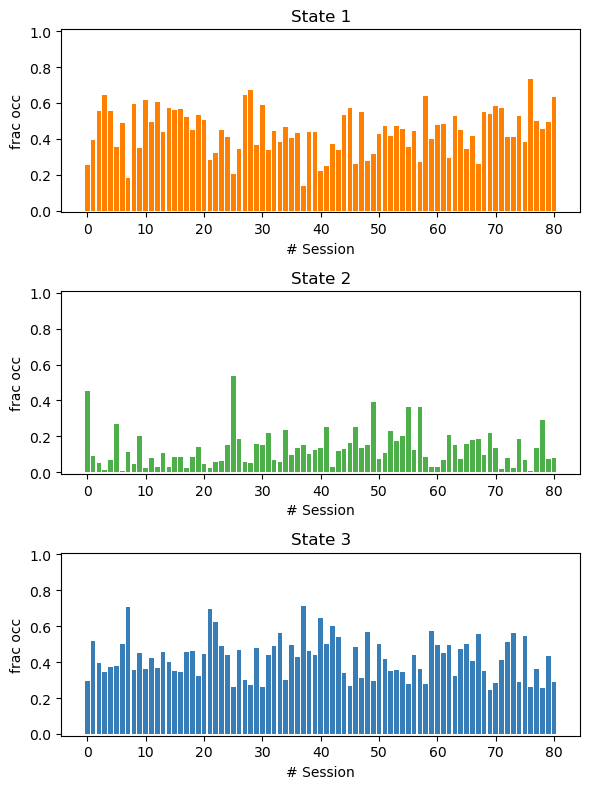

In [23]:
frac_occupancies_per_sess = get_frac_occ_across_sess(hparams, state_max_posterior)
plot_evolution_of_frac_occ(hparams, frac_occupancies_per_sess)

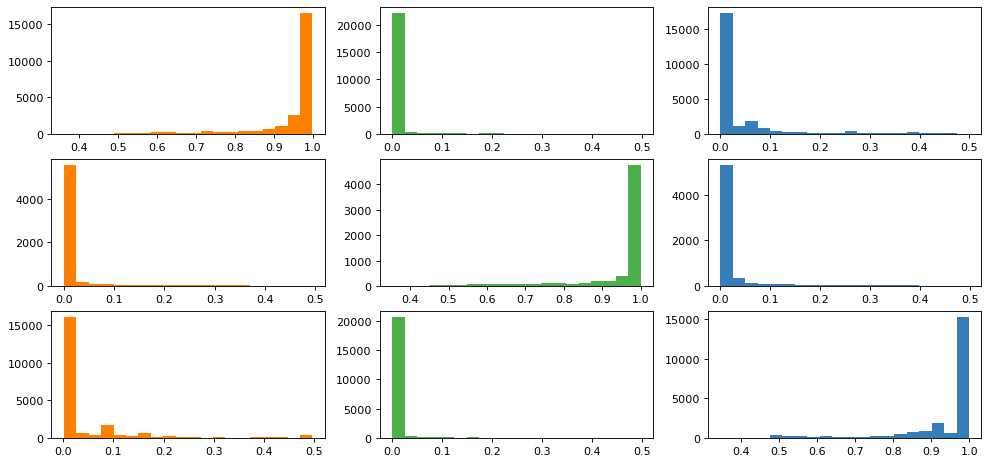

In [24]:
fig = plt.figure(figsize=(15, 7), dpi=80)

posterior_probs_concat_sess_train = np.reshape(np.array(posterior_probs) , (1,-1,num_states)).squeeze()   # (30000, 3)
for i in range(num_states):

    for j in range(num_states):
        plt.subplot(num_states,num_states,i*num_states+j+1)
        plt.hist(posterior_probs_concat_sess_train[state_max_posterior == i, j], bins = 20, color =hparams['colors'][j]) # density =True,

In [25]:
"""PCA on inputs and input-output data"""
# inpts_4pca = np.array(inpts).reshape(-1,input_dim) # good to plot
# true_choices_4pca = np.array(true_choices).reshape(-1,1) # not to plot separately
# input_output_4pca = np.concatenate((inpts_4pca, true_choices_4pca), axis=1) # good to plot
# # choices_inpts_4pca = build_input_choice_array_for_n_history_steps_all_sess_modifiedBari_encoding(hparams,data) # good to plot
# inpt_reward_part_4pca =  build_input_reward_array_for_n_history_steps_all_sess_Right1LeftMinus1Otherwise0_encoding(hparams,data) # good to plot

# # do_pca(input_output_4pca)

"""t-SNE on inputs and output data"""
# do_t_SNE(inpts_4pca, true_choices_4pca, n_components=2)


't-SNE on inputs and output data'